In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def elastic_net_loss(inputs, dictionary, alpha, lambda_1, lambda_2):
    return (0.5 * ((torch.matmul(alpha, dictionary.t()) - inputs)**2).sum(dim=1) +
            lambda_1 * torch.norm(alpha, p=1, dim=1) +
            0.5 * lambda_2 * (alpha**2).sum(dim=1))

In [3]:
def solve_elastic_net_with_ISTA(X, D, lambda_1, lambda_2, maxiter=1000):
    """
        Solve elastic net problem :
            min_alpha 0.5 * || x - D alpha ||_2**2 + lambda_1 ||alpha||_1 + 0.5 * lambda_2 ||alpha||_2**2
        using the ISTA algorithm.

        Parameters:
            X: torch tensor, size (batch_size, input_dimension)

            D: torch Tensor, size (n_dim, n_atoms)
               dictionary matrix

            lambda_1: float
                regulariation parameter in front of the l1 norm

            lambda_2: float
                regulariation parameter in front of the l2 square norm

            maxiter: int, default 1000
                maxmum number of iterations of the ISTA algorithm

        Returns:
            alpha: torch Tensor, size (batch_size, dict_size)
               the sparse code of the input batch in the dictionary D
    """

    n_atoms = D.size(1)

    identity = torch.eye(n_atoms, out=D.new(n_atoms, n_atoms))
    DtD = torch.mm(D.t(), D) + lambda_2 * identity
    XtD = torch.mm(X, D)

    with torch.no_grad():
        L = torch.svd(DtD, compute_uv=False)[1][0]
#         L = torch.symeig(DtD)[0].max().item()

    alpha = nn.functional.softshrink(1 / L * torch.matmul(X, D), lambda_1 / L)
    for i_iter in range(1, maxiter):
        alpha = alpha - 1 / L * (torch.mm(alpha, DtD) - torch.mm(X, D))
        alpha = nn.functional.softshrink(alpha, lambda_1 / L)

    return alpha



In [4]:
def analytic_gradient(X, y, D, z, W, lmbd_2):
    n_dims, n_atoms = D.shape

    assert X.shape[1] == n_dims
    batch_size = X.shape[0]

    lambda_2_identity = (lmbd_2 * torch.eye(n_atoms, out=D.new(n_atoms, n_atoms))
                         ).expand(batch_size, n_atoms, n_atoms)

    grad_W = 2 / z.shape[0] * (z.t() @ (z @ W - y))
    active_set = (z != 0).float()
    active_set_D = D.expand(batch_size, n_dims, n_atoms) * active_set[:, None]
    active_set_DtD = torch.bmm(active_set_D.transpose(1, 2), active_set_D)
    active_set_DtD += lambda_2_identity
    active_set_DtD_inverse = torch.inverse(active_set_DtD)
    grad_z = active_set * 2 * ((z @ W - y) @ W.t())
    beta = torch.bmm(active_set_DtD_inverse, grad_z[:, :, None])
    expanded_D = D.expand(batch_size, -1, -1)
    grad_D = (
            - torch.bmm(expanded_D, torch.bmm(beta, z[:, None]))
            + torch.bmm((X - torch.mm(z, D.t()))[:, :, None], beta.transpose(1, 2))
        ).mean(dim=0)
    return grad_D, grad_z, grad_W

In [5]:
def zero_grad(*args):
    for var in args:
        if var.grad is not None:
            var.grad.data.zero_()

def autograd_gradient(X, y, D, z, W, lmbd_2):
    
    zero_grad(D, W, z)
    # function to extract grad
    def set_grad(var):
        def hook(grad):
            var.grad = grad
        return hook
    z.register_hook(set_grad(z))

    loss = nn.MSELoss()
    # loss = nn.CrossEntropyLoss()
    y_pred = torch.matmul(z, W)

    output = loss(y_pred, y)
    output.backward()

    return D.grad.clone(), z.grad.clone(), W.grad.clone()

In [6]:
import numpy as np
from adopty.datasets import make_sparse_coding
from adopty.utils import check_tensor

n_samples = 100
n_dim, n_atoms = 5, 10
n_classes = 1
reg_1 = 1e-1
reg_2 = 1e-2

def get_sparse_clf(n_samples, n_dim, n_atoms, reg_1, random_state=None):
    

    X, D, z = make_sparse_coding(n_samples=n_samples, n_dim=n_dim, n_atoms=n_atoms,
                                 reg=reg_1, random_state=random_state,
                                 sparsity_filter='>0')

    W = np.random.randn(n_atoms, n_classes)
    y = z.dot(W)
    y_ = check_tensor(y)


    X_ = check_tensor(X)
    D_ = check_tensor(D + np.random.randn(*D.shape)).t()
    W_ = check_tensor(np.random.randn(*W.shape))
    D_.requires_grad = True
    W_.requires_grad = True
    
    return X_, y_, D_, W_

X_, y_, D_, W_ = get_sparse_clf(n_samples, n_dim, n_atoms, reg_1, random_state=42)

In [7]:

def pearson(g_1, g_2):
    with torch.no_grad():
        return (g_1 * g_2).sum() / \
            torch.sqrt((g_1 * g_1).sum() * (g_2*g_2).sum())


In [8]:
# z_inf = solve_elastic_net_with_ISTA(X_, D_, reg_1, reg_2, maxiter=100000)
# ana_grad = analytic_gradient(X_, y_, D_, z_inf, W_, reg_2)
# auto_grad = autograd_gradient(X_, y_, D_, z_inf, W_, reg_2)
# for g, gg in zip(ana_grad, auto_grad):
#     print(pearson(g, gg))

In [9]:
names = ['D', 'z', 'W']
n_rep = 3

from collections import namedtuple
ResultItem = namedtuple('ResultItem', ['it', 'reg_1', 'reg2'] +
                        [f'{n}_{t}' for n in names for t in ['auto', 'ana']])

res = []
for rep in range(n_rep):
    X_, y_, D_, W_ = get_sparse_clf(n_samples, n_dim, n_atoms, reg_1)

    with torch.no_grad():
        z_inf = solve_elastic_net_with_ISTA(X_, D_, reg_1, reg_2, maxiter=100000)
    ref = analytic_gradient(X_, y_, D_, z_inf, W_, reg_2)
    for it in np.logspace(1, 4, 15, dtype=int):
        print("\n" + "=" * 80 + f"\n Iter {it}\n" + "="*80)
        print("           Autograd  Analytic")
        z_t = solve_elastic_net_with_ISTA(X_, D_, reg_1, reg_2, maxiter=it)
        grad_auto = autograd_gradient(X_, y_, D_, z_t, W_, reg_2)
        grad_ana = analytic_gradient(X_, y_, D_, z_t, W_, reg_2)
        
        pearsons = []
        for name, g_inf, g_auto, g_ana in zip(names, ref, grad_auto, grad_ana):
            diff_auto = pearson(g_auto, g_inf)
            diff_ana = pearson(g_ana, g_inf)
            print(f"Pearson {name}: {diff_auto:.3e} {diff_ana:.3e}")
            pearsons += [diff_auto.item(), diff_ana.item()]
        res.append(ResultItem(it, reg_1, reg_2, *pearsons))
    gc.collect()
import pandas as pd
df = pd.DataFrame(res)


 Iter 10
           Autograd  Analytic
Pearson D: 5.552e-01 5.590e-02
Pearson z: 6.605e-01 7.127e-01
Pearson W: 9.352e-01 9.352e-01

 Iter 16
           Autograd  Analytic
Pearson D: 6.464e-01 4.123e-02
Pearson z: 6.605e-01 7.269e-01
Pearson W: 9.406e-01 9.406e-01

 Iter 26
           Autograd  Analytic
Pearson D: 6.962e-01 2.336e-02
Pearson z: 6.606e-01 7.675e-01
Pearson W: 9.495e-01 9.495e-01

 Iter 43
           Autograd  Analytic
Pearson D: 7.151e-01 4.611e-02
Pearson z: 6.606e-01 7.955e-01
Pearson W: 9.624e-01 9.624e-01

 Iter 71
           Autograd  Analytic
Pearson D: 7.705e-01 1.124e-01
Pearson z: 6.607e-01 8.430e-01
Pearson W: 9.776e-01 9.776e-01

 Iter 117
           Autograd  Analytic
Pearson D: 7.779e-01 1.464e-01
Pearson z: 6.607e-01 9.062e-01
Pearson W: 9.908e-01 9.908e-01

 Iter 193
           Autograd  Analytic
Pearson D: 7.802e-01 2.108e-01
Pearson z: 6.607e-01 9.462e-01
Pearson W: 9.976e-01 9.976e-01

 Iter 316
           Autograd  Analytic
Pearson D: 6.988e-01 2.251

Pearson D: 9.983e-01 9.965e-01
Pearson z: 5.982e-01 9.962e-01
Pearson W: 1.000e+00 1.000e+00

 Iter 6105
           Autograd  Analytic
Pearson D: 9.983e-01 9.987e-01
Pearson z: 5.982e-01 9.995e-01
Pearson W: 1.000e+00 1.000e+00

 Iter 10000
           Autograd  Analytic
Pearson D: 9.995e-01 1.000e+00
Pearson z: 5.982e-01 1.000e+00
Pearson W: 1.000e+00 1.000e+00

 Iter 10
           Autograd  Analytic
Pearson D: 2.201e-01 7.958e-03
Pearson z: 6.387e-01 6.712e-01
Pearson W: 7.847e-01 7.847e-01

 Iter 16
           Autograd  Analytic
Pearson D: 2.913e-01 7.820e-02
Pearson z: 6.387e-01 6.880e-01
Pearson W: 8.147e-01 8.147e-01

 Iter 26
           Autograd  Analytic
Pearson D: 2.839e-01 2.049e-02
Pearson z: 6.386e-01 6.964e-01
Pearson W: 8.417e-01 8.417e-01

 Iter 43
           Autograd  Analytic
Pearson D: 2.382e-01 3.804e-02
Pearson z: 6.385e-01 7.186e-01
Pearson W: 8.693e-01 8.693e-01

 Iter 71
           Autograd  Analytic
Pearson D: 5.632e-01 4.283e-01
Pearson z: 6.385e-01 7.783e-01
Pe

In [10]:
df_ = df.groupby('it').mean()

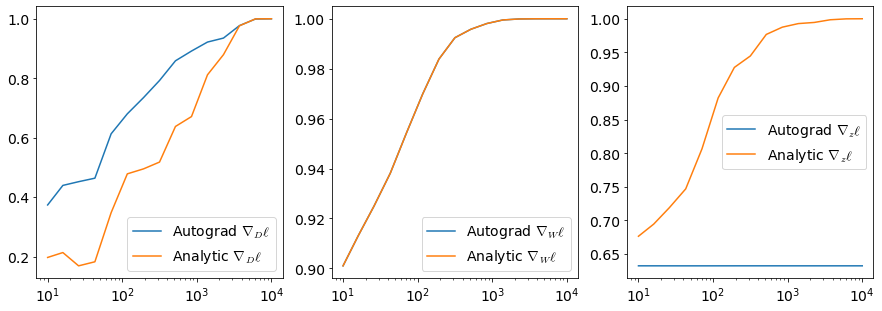

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].semilogx(df_.index, df_.D_auto, label=r'Autograd $\nabla_D \ell$')
axes[0].semilogx(df_.index, df_.D_ana, label=r'Analytic $\nabla_D \ell$')
axes[0].legend(fontsize=14)

axes[1].semilogx(df_.index, df_.W_auto, label=r'Autograd $\nabla_W \ell$')
axes[1].semilogx(df_.index, df_.W_ana, label=r'Analytic $\nabla_W \ell$')
axes[1].legend(fontsize=14)

axes[2].semilogx(df_.index, df_.z_auto, label=r'Autograd $\nabla_z \ell$')
axes[2].semilogx(df_.index, df_.z_ana, label=r'Analytic $\nabla_z \ell$')
axes[2].legend(fontsize=14)

In [14]:
import gc
gc.collect()

0